## Findings so far.
### Grouping on date, I found the following:
- Markdowns are mostly missing in the first half of the data, from 2011-11-11 there are barely any missing values (only 7 missing for MarkDown2, the rest is 100%)
- Weekly Sales are missing from 2012-10-26 onwards
- CPI and Unemployment are missing from 2013-05-03 onwards

So, from 2011-11-11 until 2013-05-03 there is Markdown data, so atleast for a full year. We can check differences between e.g. 2011-11-11 and 2012-11-11 (may need to convert to week numbers). From here we can potentially work to a substitution for the missing values, taking an average for example. Hopefully differences are not too big. Don't forget about markdown2.

Then we could predict sales based on markdowns + CPI + unemployment + fuel price + IsHoliday + temperature for the period 2012-10-26 until 2013-05-03 atleast. There will be no missing values until that date.

From there on use linear regression + random forest. Train/test split 80/20 over the period until 2012-10-26. Then predict values for 2012-10-26 until 2013-05-03.


Other ideas: 
- take best and worst performing store or department and see how they differ in Markdown strategy. 
- cluster on temperature or fuel price etc. to see if it affects sales in any way. Maybe with only holiday = TRUE
-  

And, what do we do with the fact that "This weeks, including these holidays, are weighted five times higher in the evaluation then non-holiday weeks." 



In [1]:
# importing necessary libraries
import os
import numpy as np   
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Copy and paste the path of the directory that holds your data to the path variable
path = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"
os.chdir(path)
print(cwd)

C:\Users\blk\OneDrive\Documenten\GitHub\ML-Final\AppliedML_Assign.01\Assignment2\Data


In [10]:
# Loading data
features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

In [14]:
features.info()
features.head()
features.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,26/07/2013,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [151]:
features.Temperature.describe()

count    8190.000000
mean       59.356198
std        18.678607
min        -7.290000
25%        45.902500
50%        60.710000
75%        73.880000
max       101.950000
Name: Temperature, dtype: float64

In [152]:
features.Fuel_Price.describe()

count    8190.000000
mean        3.405992
std         0.431337
min         2.472000
25%         3.041000
50%         3.513000
75%         3.743000
max         4.468000
Name: Fuel_Price, dtype: float64

In [153]:
holiday_count = features['IsHoliday'].sum()
print(holiday_count)


585


In [104]:
print(
    features.MarkDown5.describe(), '\n',
    features.MarkDown5.isna().sum()
)

count      4050.000000
mean       4132.216422
std       13086.690278
min        -185.170000
25%        1440.827500
50%        2727.135000
75%        4832.555000
max      771448.100000
Name: MarkDown5, dtype: float64 
 4140


In [12]:
sales.info()
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [13]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [15]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

In [107]:
print(features.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


In [127]:
features_grouped = features.groupby("Date").agg({"Temperature": "mean",
                                                     "Fuel_Price": "mean",
                                                     "CPI": "mean",
                                                     "Unemployment": "mean",
                                                      "IsHoliday": "min",
                                                      "MarkDown1": "mean",
                                                      "MarkDown2": "mean",
                                                      "MarkDown3": "mean",
                                                      "MarkDown4": "mean",
                                                      "MarkDown5": "mean"})
print(
    features_grouped.shape, '\n',
    features_grouped.head(3)
)



(182, 10) 
             Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
Date                                                                       
2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
2010-02-12    34.151333    2.694022  167.825608      8.619311       True   
2010-02-19    37.719778    2.672067  167.871686      8.619311      False   

            MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  
Date                                                               
2010-02-05        NaN        NaN        NaN        NaN        NaN  
2010-02-12        NaN        NaN        NaN        NaN        NaN  
2010-02-19        NaN        NaN        NaN        NaN        NaN  


In [149]:
print(
    features_grouped[92:].MarkDown5.isna().sum(), '\n',
    features_grouped[90:95], '\n',
    features_grouped[-1:]
)

0 
             Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
Date                                                                       
2011-10-28    56.468889    3.541022  173.046419      7.804222      False  \
2011-11-04    49.200000    3.522044  173.123477      7.804222      False   
2011-11-11    49.112444    3.488711  173.200535      7.804222      False   
2011-11-18    52.191556    3.487400  173.300470      7.804222      False   
2011-11-25    49.627556    3.434311  173.409555      7.804222       True   

               MarkDown1    MarkDown2     MarkDown3    MarkDown4    MarkDown5  
Date                                                                           
2011-10-28           NaN          NaN           NaN          NaN          NaN  
2011-11-04           NaN          NaN           NaN          NaN          NaN  
2011-11-11  10732.220667  9031.857778    301.183864  4122.438378  4946.894444  
2011-11-18   5998.128000   650.518864    114.090250   815.50289

# FUN fact, almost all NaN markdown values are before and including 2011-11-04, after this date, only markdown 2 has 7 missing values, the rest 0.

So, we have basically all markdown values available from 2011-11-11 onwards

In [125]:
print(features_grouped.MarkDown2.isna().sum())

99


In [106]:
features_grouped = features.groupby("Date").agg({"Temperature": "mean",
                                                     "Fuel_Price": "mean",
                                                     "CPI": "mean",
                                                     "Unemployment": "mean",
                                                      "IsHoliday": "min"})
print(
    features_grouped.shape, '\n',
    features_grouped.tail()
)


(182, 5) 
             Temperature  Fuel_Price  CPI  Unemployment  IsHoliday
Date                                                             
2013-06-28    79.871111    3.629400  NaN           NaN      False
2013-07-05    79.655778    3.583533  NaN           NaN      False
2013-07-12    80.798667    3.568111  NaN           NaN      False
2013-07-19    79.268667    3.683444  NaN           NaN      False
2013-07-26    78.037333    3.734444  NaN           NaN      False


In [67]:
print(features_grouped.columns)


Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday'], dtype='object')


In [72]:
# Count NaN values for 'CPI'
nan_cpi_count = features_grouped['CPI'].isna().sum()

print(f"Number of NaN values in 'CPI': {nan_cpi_count}")

print(features_grouped[-20:])

Number of NaN values in 'CPI': 13
            Temperature  Fuel_Price         CPI  Unemployment  IsHoliday
Date                                                                    
2013-03-15    48.728000    3.751467  177.740876      6.876444      False
2013-03-22    49.300889    3.747267  177.803327      6.876444      False
2013-03-29    46.997111    3.731667  177.865778      6.876444      False
2013-04-05    52.718222    3.704644  177.928229      6.719244      False
2013-04-12    55.050222    3.671044  177.990680      6.719244      False
2013-04-19    56.745556    3.618156  177.990680      6.719244      False
2013-04-26    55.033778    3.586022  177.990680      6.719244      False
2013-05-03    61.780444    3.536933         NaN           NaN      False
2013-05-10    62.092444    3.542822         NaN           NaN      False
2013-05-17    66.612889    3.604333         NaN           NaN      False
2013-05-24    69.696889    3.649556         NaN           NaN      False
2013-05-31    69.

In [68]:
# Filter rows where 'CPI' has NaN values
nan_cpi_rows = features_grouped[features_grouped['CPI'].isna()]

# Display the dates (indices) with NaN values for 'CPI'
print(nan_cpi_rows.index)


DatetimeIndex(['2013-05-03', '2013-05-10', '2013-05-17', '2013-05-24',
               '2013-05-31', '2013-06-07', '2013-06-14', '2013-06-21',
               '2013-06-28', '2013-07-05', '2013-07-12', '2013-07-19',
               '2013-07-26'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [58]:
sales_grouped = sales.groupby("Date").agg({"Weekly_Sales" : "sum"})
sales_grouped["Weekly_Sales"] = (sales_grouped["Weekly_Sales"] / 1e6).astype(int)
sales_grouped.tail()

,Weekly_Sales
Date,
2012-09-28,43
2012-10-05,47
2012-10-12,46
2012-10-19,45
2012-10-26,45


In [57]:
# now: create a merged dataframe
data_datewise = pd.merge(features_grouped, sales_grouped, on=["Date"], how="left").reset_index()
data_datewise.tail()

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales
177,2013-06-28,79.871111,3.629400,NaN,NaN,False,NaN
178,2013-07-05,79.655778,3.583533,NaN,NaN,False,NaN
179,2013-07-12,80.798667,3.568111,NaN,NaN,False,NaN
180,2013-07-19,79.268667,3.683444,NaN,NaN,False,NaN
181,2013-07-26,78.037333,3.734444,NaN,NaN,False,NaN


In [75]:
print(data_datewise[-50:])


          Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
132 2012-08-17    79.432222    3.720511  175.743527      7.237333      False  \
133 2012-08-24    74.592889    3.759644  175.833841      7.237333      False   
134 2012-08-31    77.793556    3.769067  175.924154      7.237333      False   
135 2012-09-07    78.038667    3.842556  176.014468      7.237333       True   
136 2012-09-14    70.238222    3.852044  176.110660      7.237333      False   
137 2012-09-21    67.924889    3.907911  176.242124      7.237333      False   
138 2012-09-28    68.754444    3.854578  176.373588      7.237333      False   
139 2012-10-05    65.973111    3.845222  176.505052      6.953711      False   
140 2012-10-12    58.342667    3.896733  176.636515      6.953711      False   
141 2012-10-19    60.705333    3.880000  176.652613      6.953711      False   
142 2012-10-26    61.051111    3.791489  176.649482      6.953711      False   
143 2012-11-02    54.615556    3.676289 

# Apparently there is no more sales data from index 142 (2012-10-26) onwards, CPI and Unemployment are not available as of 169 onwards (2013-05-03)
## seems reasonable to continue with a slice of the data up to and including 142

In [78]:
data = data_datewise[0:143]
print(data.tail())

          Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
138 2012-09-28    68.754444    3.854578  176.373588      7.237333      False  \
139 2012-10-05    65.973111    3.845222  176.505052      6.953711      False   
140 2012-10-12    58.342667    3.896733  176.636515      6.953711      False   
141 2012-10-19    60.705333    3.880000  176.652613      6.953711      False   
142 2012-10-26    61.051111    3.791489  176.649482      6.953711      False   

     Weekly_Sales  
138          43.0  
139          47.0  
140          46.0  
141          45.0  
142          45.0  


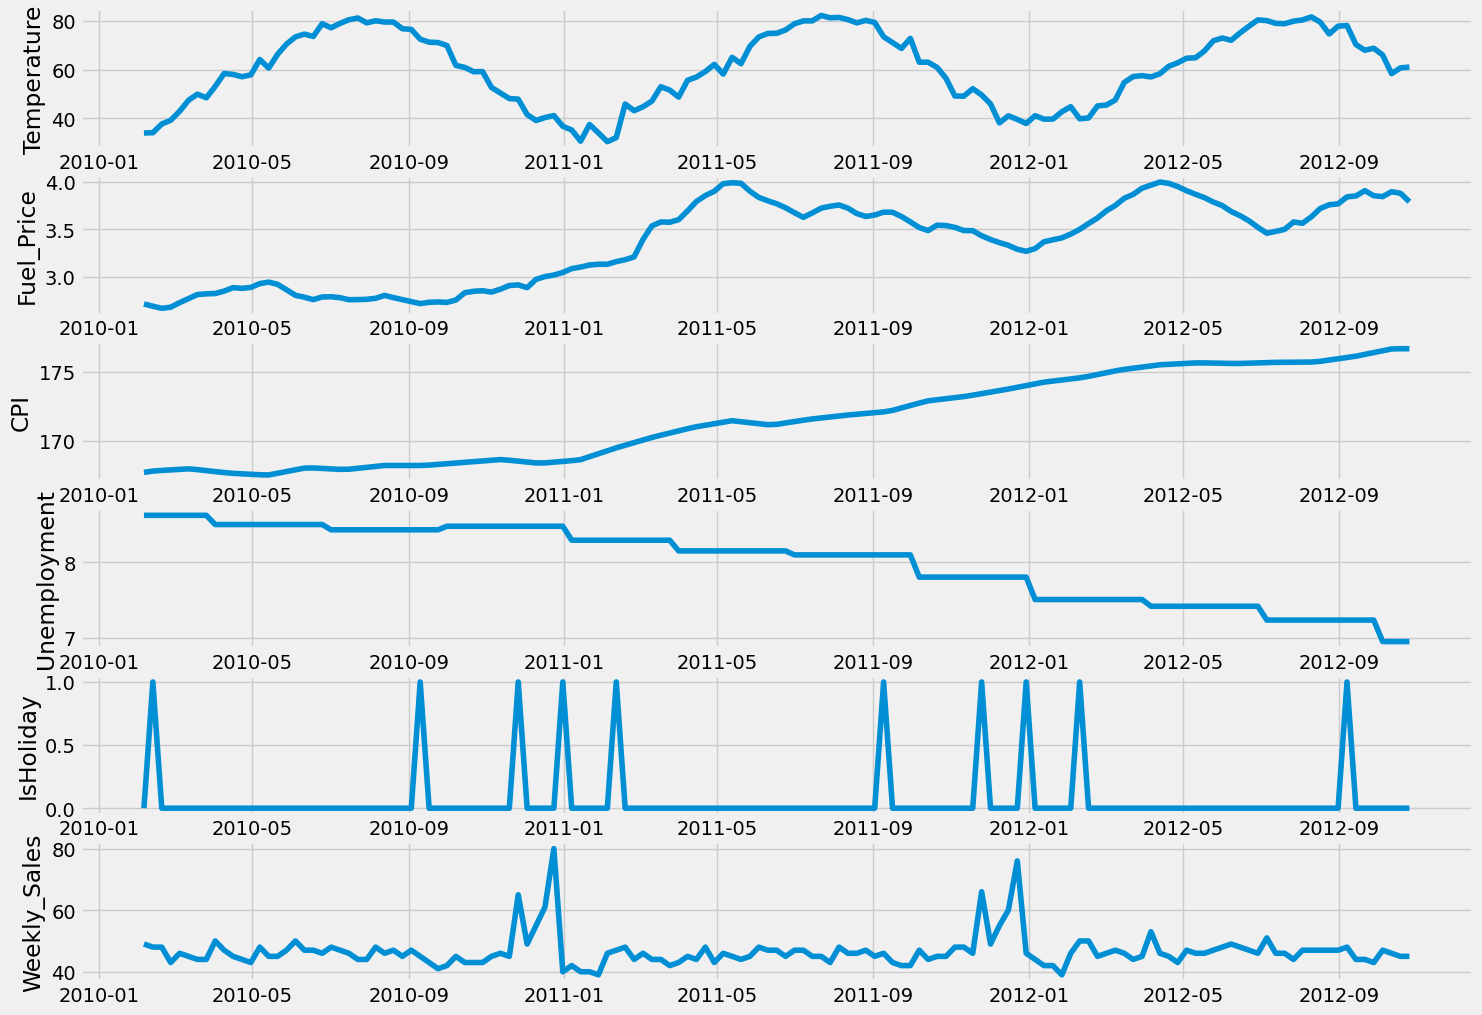

In [79]:
fig = plt.figure(figsize = (16, 12))
count_columns_ex_date = len(data.columns[1:])
for idx, col in enumerate(data.columns[1:]):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(data["Date"], data[col])
    plt.ylabel(col)
    

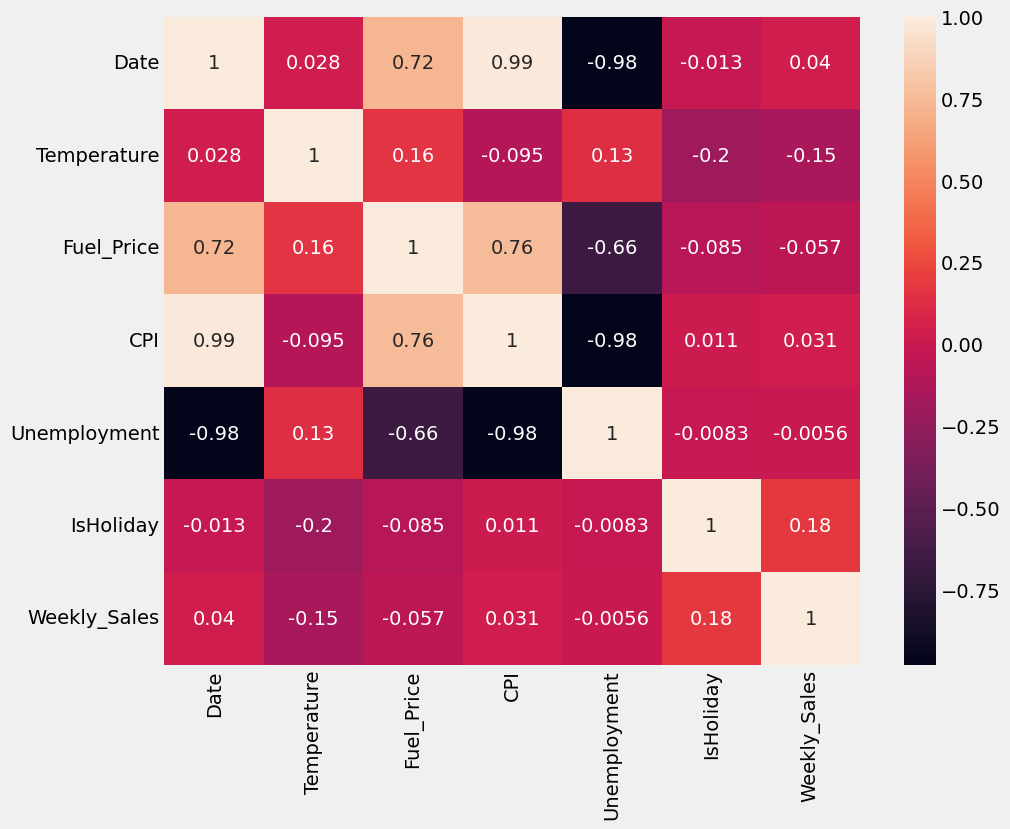

In [84]:
plt.figure(figsize=(10,8))
sns.heatmap(data_datewise.corr(),annot=True)
plt.show()

In [89]:
# Set 'Date' as the index
data.set_index('Date', inplace=True)

Text(0, 0.5, 'Sales')

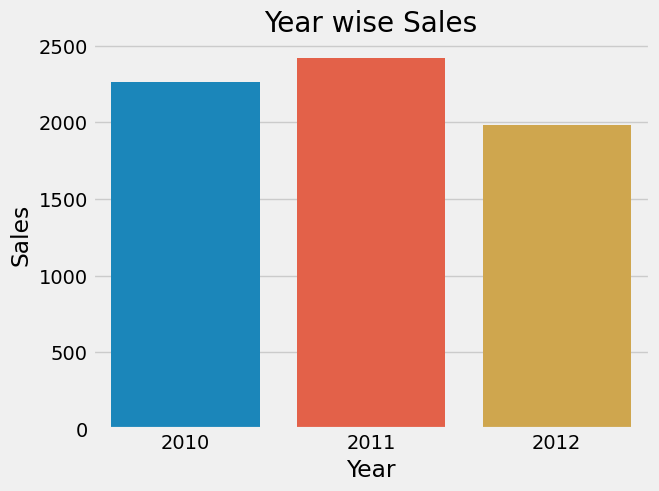

In [91]:
data_sales_year = data.groupby(data.index.year).agg({"Weekly_Sales":"sum"})
sns.barplot(x=data_sales_year.index,y=data_sales_year.Weekly_Sales)
plt.title("Year wise Sales")
plt.xlabel("Year")
plt.ylabel("Sales")